In [1]:
import dask.dataframe as dd
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import dask
import numpy as np
from pyensembl import EnsemblRelease
pd.set_option('display.max_columns', None)


from scripts.pyensembl_operations import import_pyensembl
g37 = import_pyensembl(37)


INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/nazo/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/nazo/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /Users/nazo/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.pep.all.fa.gz.pickle


In [2]:
df = pd.read_csv("results/the_final_data.csv")

# add filter col
filter_logic = (abs(df['log2_odds_ratio']) > 0.32) & (df['p_adj'] < 0.05)
df["is_significant"] = filter_logic
df['is_gene_upregulated'] = df['log2_odds_ratio'] >= 0

# add genes table
sqlite_conn = sqlite3.connect('data/mirscribe_backup.db')
genes = pd.read_sql('SELECT * FROM genes', sqlite_conn)
mirnas = pd.read_sql('SELECT * FROM mirnas', sqlite_conn)
sqlite_conn.close()


# add genes table details
cols_to_merge = ['gene_id', 'is_oncogene_oncokb', 'is_tsupp_oncokb',
       'is_driver_intogen', 'tier_cosmic', 'is_hallmark_cosmic',
       'is_tsupp_cosmic', 'is_oncogene_cosmic', 'is_oncogene_consensus',
       'is_tsupp_consensus', 'is_gene_of_interest', 'cancer_gene_role']

df = pd.merge(df, genes[cols_to_merge], how="left", on="gene_id" )



df.head()


,gene_id,upregulated_real,downregulated_real,upregulated_synth,downregulated_synth,log2_odds_ratio,p_value,p_adj,z_score,gene_name,biotype,is_significant,is_gene_upregulated,is_oncogene_oncokb,is_tsupp_oncokb,is_driver_intogen,tier_cosmic,is_hallmark_cosmic,is_tsupp_cosmic,is_oncogene_cosmic,is_oncogene_consensus,is_tsupp_consensus,is_gene_of_interest,cancer_gene_role
0,ENSG00000198586,2741,1457,3337.6,1559.0,-0.186474,3.952448e-03,0.014360,-0.264947,TLK1,protein_coding,False,False,0,0,0,0,0,0,0,0,0,0,neither
1,ENSG00000227367,1392,736,985.7,484.8,-0.104083,3.163041e-01,0.494740,-0.201436,SLC9B1P4,pseudogene,False,False,0,0,0,0,0,0,0,0,0,0,neither
2,ENSG00000233080,2126,590,1833.1,636.8,0.323838,5.930840e-04,0.002862,0.128432,CTA-714B7.5,lincRNA,True,True,0,0,0,0,0,0,0,0,0,0,neither
3,ENSG00000153827,1958,1016,2305.2,1217.4,0.025330,7.530856e-01,0.909248,-0.101676,TRIP12,protein_coding,False,True,0,0,0,0,0,0,0,0,0,0,neither
4,ENSG00000225889,1590,881,2086.9,852.9,-0.438965,1.925104e-07,0.000003,-0.459583,AC074289.1,antisense,True,False,0,0,0,0,0,0,0,0,0,0,neither


In [ ]:
onc = df.is_oncogene_consensus == True
tsupp = df.is_tsupp_consensus == True

upreg = df.is_gene_upregulated == True
downreg = df.is_gene_upregulated == False

sign = df.is_significant == True

sign_onc_list = df[onc & sign]['gene_id'].tolist()
sign_tsupp_list = df[tsupp & sign]['gene_id'].tolist()

sign_upreg_list = df[upreg & sign]['gene_id'].tolist()
sign_downreg_list = df[downreg & sign]['gene_id'].tolist()

# Create sets for significantly up/down regulated oncogenes and tumor suppressors
up_onc = set(sign_onc_list) & set(sign_upreg_list)
up_tsupp = set(sign_tsupp_list) & set(sign_upreg_list)
down_onc = set(sign_onc_list) & set(sign_downreg_list)
down_tsupp = set(sign_tsupp_list) & set(sign_downreg_list)


# bringing real data

In [ ]:
real = dd.read_parquet("results/processed/real/0/*.parquet")

cols_to_merge_genes = ['gene_id', 'is_oncogene_consensus',
       'is_tsupp_consensus']

cols_to_merge_mirna = ['mirna_accession', 'mirna_family', 'is_mirna_oncogene', 'is_mirna_tumor_suppressor']

import dask.dataframe as dd
import pandas as pd
import sqlite3

with sqlite3.connect('data/mirscribe_backup.db') as conn:
    genes = pd.read_sql_query("SELECT * FROM genes", conn)

genes_dd = dd.from_pandas(genes[cols_to_merge_genes], npartitions=1)
genes_dd['gene_id'] = genes_dd['gene_id'].astype('string[pyarrow]')

with sqlite3.connect('data/mirscribe_backup.db') as conn:
    mirnas = pd.read_sql_query("SELECT * FROM mirnas", conn)

mirnas_dd = dd.from_pandas(mirnas[cols_to_merge_mirna], npartitions=1)
mirnas_dd['mirna_accession'] = mirnas_dd['mirna_accession'].astype('string[pyarrow]')

real['gene_id'] = real['gene_id'].astype('string[pyarrow]')
real['mirna_accession'] = real['mirna_accession'].astype('string[pyarrow]')

real = real.merge(genes_dd, how="left", on="gene_id")
real = real.merge(mirnas_dd, how="left", on="mirna_accession")


# Ensuring the dtype consistency before dropping
real['wt_prediction'] = real['wt_prediction'].astype('string[pyarrow]')
real['mut_prediction'] = real['mut_prediction'].astype('string[pyarrow]')
real['mutsig_key'] = real['mutsig_key'].astype('string[pyarrow]')
real['experiment'] = real['experiment'].astype('string[pyarrow]')

cols_to_drop = [
    'wt_prediction',
    'mut_prediction',
    'mutsig_key',
    'experiment'
]

real = real.drop(columns=cols_to_drop)


real.is_oncogene_consensus = real.is_oncogene_consensus.astype('bool')
real.is_tsupp_consensus = real.is_tsupp_consensus.astype('bool')
real.is_mirna_oncogene = real.is_mirna_oncogene.astype('bool')
real.is_mirna_tumor_suppressor = real.is_mirna_tumor_suppressor.astype('bool')

In [ ]:


# Get distributions using these sets
up_onc_dist = real[real.gene_id.isin(up_onc)].mutsig.value_counts().compute()
up_tsupp_dist = real[real.gene_id.isin(up_tsupp)].mutsig.value_counts().compute()
down_onc_dist = real[real.gene_id.isin(down_onc)].mutsig.value_counts().compute()
down_tsupp_dist = real[real.gene_id.isin(down_tsupp)].mutsig.value_counts().compute()


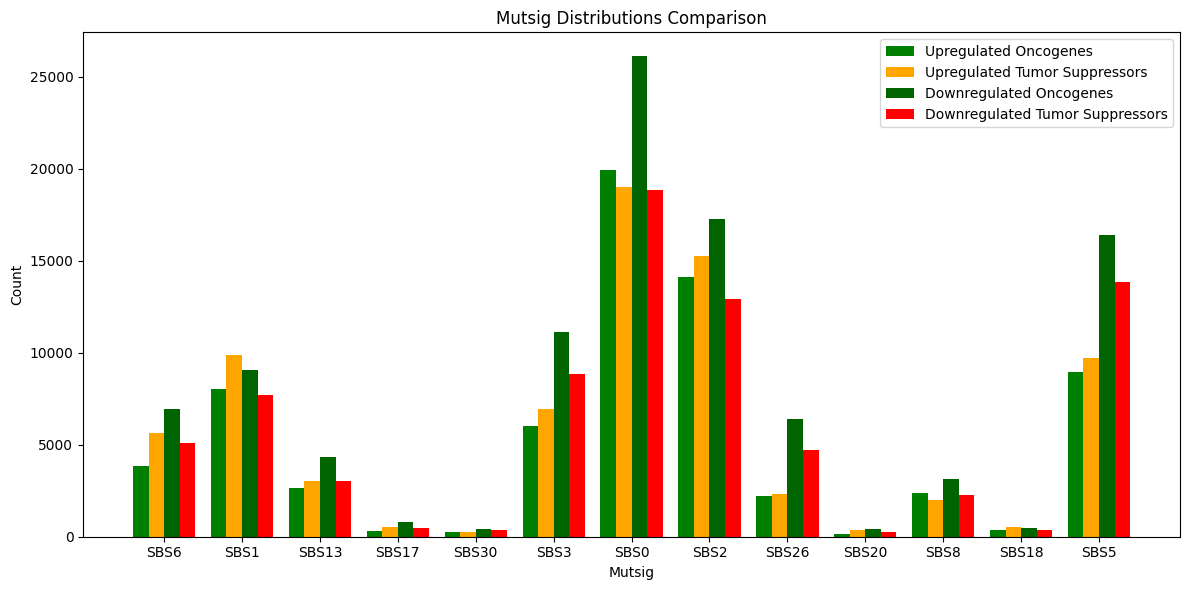

In [6]:
# Set up the plot
plt.figure(figsize=(12, 6))

# Set width of bars and positions
bar_width = 0.2
r1 = np.arange(len(up_onc_dist))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create bars
plt.bar(r1, up_onc_dist.values, width=bar_width, label='Upregulated Oncogenes', color='green')
plt.bar(r2, up_tsupp_dist.values, width=bar_width, label='Upregulated Tumor Suppressors', color='orange')
plt.bar(r3, down_onc_dist.values, width=bar_width, label='Downregulated Oncogenes', color='darkgreen')
plt.bar(r4, down_tsupp_dist.values, width=bar_width, label='Downregulated Tumor Suppressors', color='red')

# Add labels and title
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Mutsig Distributions Comparison')
plt.xticks([r + bar_width*1.5 for r in range(len(up_onc_dist))], up_onc_dist.index)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

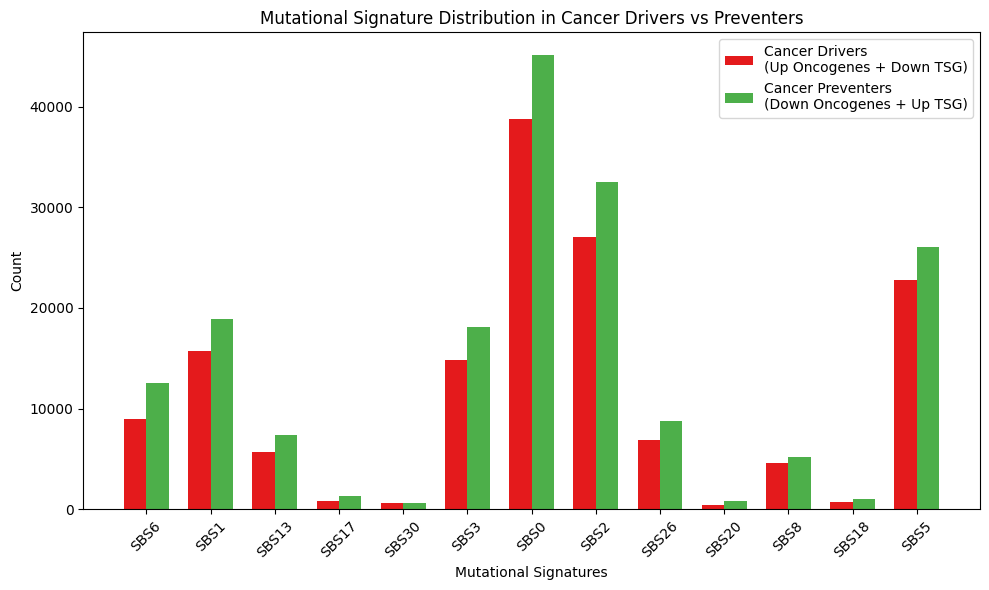

In [7]:
# Combine distributions
cancer_drivers = up_onc_dist + down_tsupp_dist  # promoting cancer
cancer_preventers = down_onc_dist + up_tsupp_dist  # preventing cancer

# Set up the plot
plt.figure(figsize=(10, 6))

# Set width of bars and positions 
bar_width = 0.35
r1 = np.arange(len(cancer_drivers))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, cancer_drivers.values, width=bar_width, label='Cancer Drivers\n(Up Oncogenes + Down TSG)', color='#e41a1c')  # Red
plt.bar(r2, cancer_preventers.values, width=bar_width, label='Cancer Preventers\n(Down Oncogenes + Up TSG)', color='#4daf4a')  # Green

# Add labels and title
plt.xlabel('Mutational Signatures')
plt.ylabel('Count')
plt.title('Mutational Signature Distribution in Cancer Drivers vs Preventers')
plt.xticks([r + bar_width/2 for r in range(len(cancer_drivers))], cancer_drivers.index, rotation=45)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


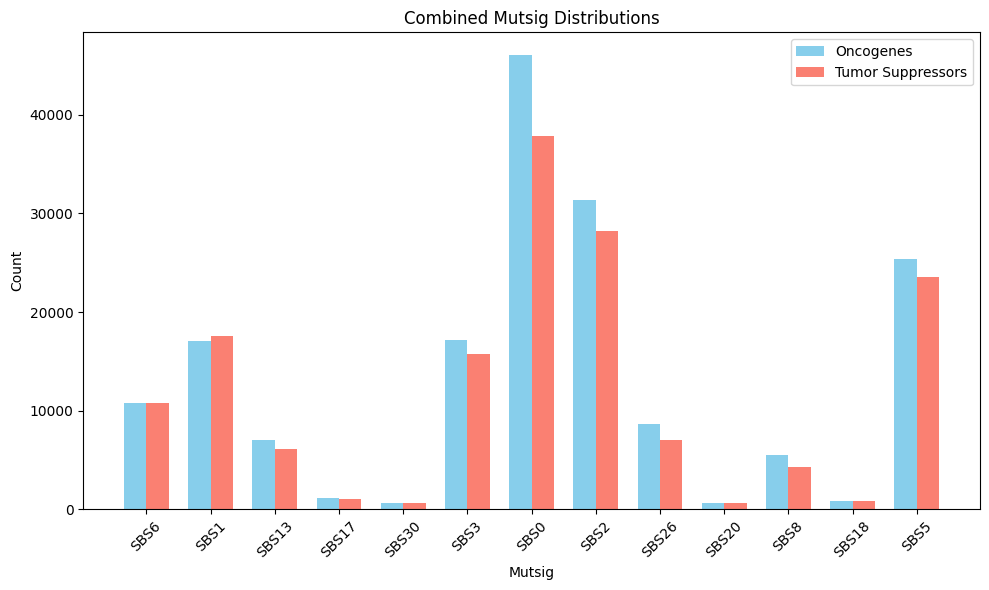

In [8]:
# Combine oncogenes (up + down)
combined_oncogenes_dist = up_onc_dist + down_onc_dist

# Combine tumor suppressors (up + down)
combined_tsupps_dist = up_tsupp_dist + down_tsupp_dist

# Set up the plot
plt.figure(figsize=(10, 6))

# Set width of bars and positions 
bar_width = 0.35
r1 = np.arange(len(combined_oncogenes_dist))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, combined_oncogenes_dist.values, width=bar_width, label='Oncogenes', color='skyblue')
plt.bar(r2, combined_tsupps_dist.values, width=bar_width, label='Tumor Suppressors', color='salmon')

# Add labels and title
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Combined Mutsig Distributions')
plt.xticks([r + bar_width/2 for r in range(len(combined_oncogenes_dist))], combined_oncogenes_dist.index, rotation=45)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


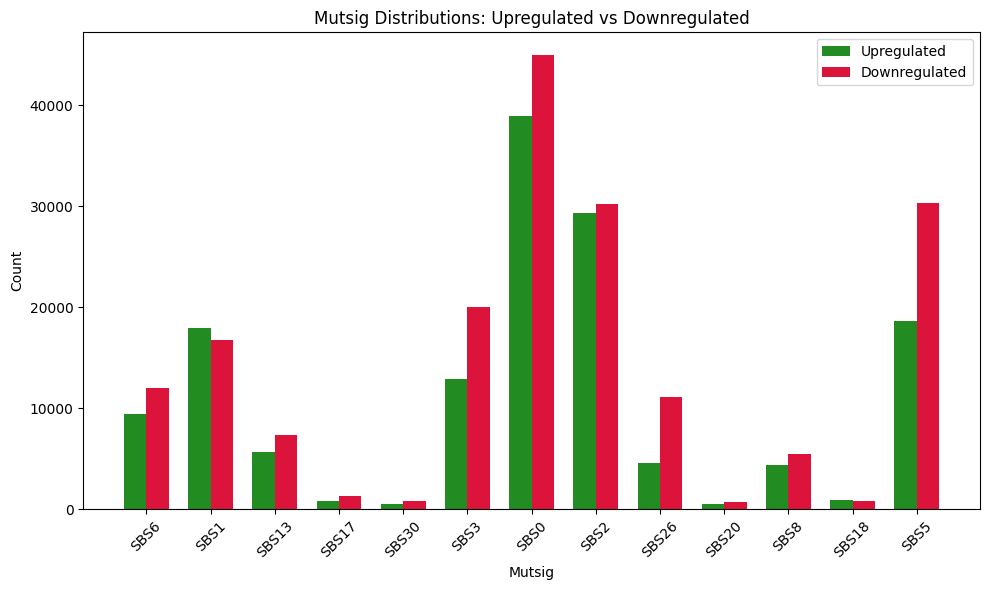

In [9]:
# Combine all upregulated (oncogenes + tsupps)
all_upreg_dist = up_onc_dist + up_tsupp_dist

# Combine all downregulated (oncogenes + tsupps)
all_downreg_dist = down_onc_dist + down_tsupp_dist

# Set up the plot
plt.figure(figsize=(10, 6))

# Set width of bars and positions 
bar_width = 0.35
r1 = np.arange(len(all_upreg_dist))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, all_upreg_dist.values, width=bar_width, label='Upregulated', color='forestgreen')
plt.bar(r2, all_downreg_dist.values, width=bar_width, label='Downregulated', color='crimson')

# Add labels and title
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Mutsig Distributions: Upregulated vs Downregulated')
plt.xticks([r + bar_width/2 for r in range(len(all_upreg_dist))], all_upreg_dist.index, rotation=45)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


In [18]:
real.head()

,id,pred_difference,vcf_id,mirna_accession,gene_id,is_intron,mutation_context,is_gene_upregulated,mutsig,gene_name,biotype,cancer_type,is_oncogene_consensus,is_tsupp_consensus,mirna_family,is_mirna_oncogene,is_mirna_tumor_suppressor
0,PD3851a_1_12852166_G_T_MIMAT0000100,-0.337,PD3851a,MIMAT0000100,ENSG00000116721,True,C[C>A]G,True,SBS5,PRAMEF1,protein_coding,ppn,False,False,miR-29-3p,False,False
1,PD3851a_1_12852166_G_T_MIMAT0002881,-0.232,PD3851a,MIMAT0002881,ENSG00000116721,True,C[C>A]G,True,SBS5,PRAMEF1,protein_coding,ppn,False,False,miR-509-3p,False,False
2,PD3851a_1_12852166_G_T_MIMAT0003238,-0.225,PD3851a,MIMAT0003238,ENSG00000116721,True,C[C>A]G,True,SBS5,PRAMEF1,protein_coding,ppn,False,False,miR-573/3616-5p,False,False
3,PD3851a_1_12852166_G_T_MIMAT0003248,-0.295,PD3851a,MIMAT0003248,ENSG00000116721,True,C[C>A]G,True,SBS5,PRAMEF1,protein_coding,ppn,False,False,miR-583,False,False
4,PD3851a_1_12852166_G_T_MIMAT0003250,-0.324,PD3851a,MIMAT0003250,ENSG00000116721,True,C[C>A]G,True,SBS5,PRAMEF1,protein_coding,ppn,False,False,miR-585-3p,False,False


In [ ]:
sign_upreg_list = df[upreg & sign]['gene_id'].tolist()
sign_downreg_list = df[downreg & sign]['gene_id'].tolist()

all_upregulated_dist = real[real.gene_id.isin(sign_upreg_list)].mutsig.value_counts().compute()
all_downregulated_dist = real[real.gene_id.isin(sign_downreg_list)].mutsig.value_counts().compute()


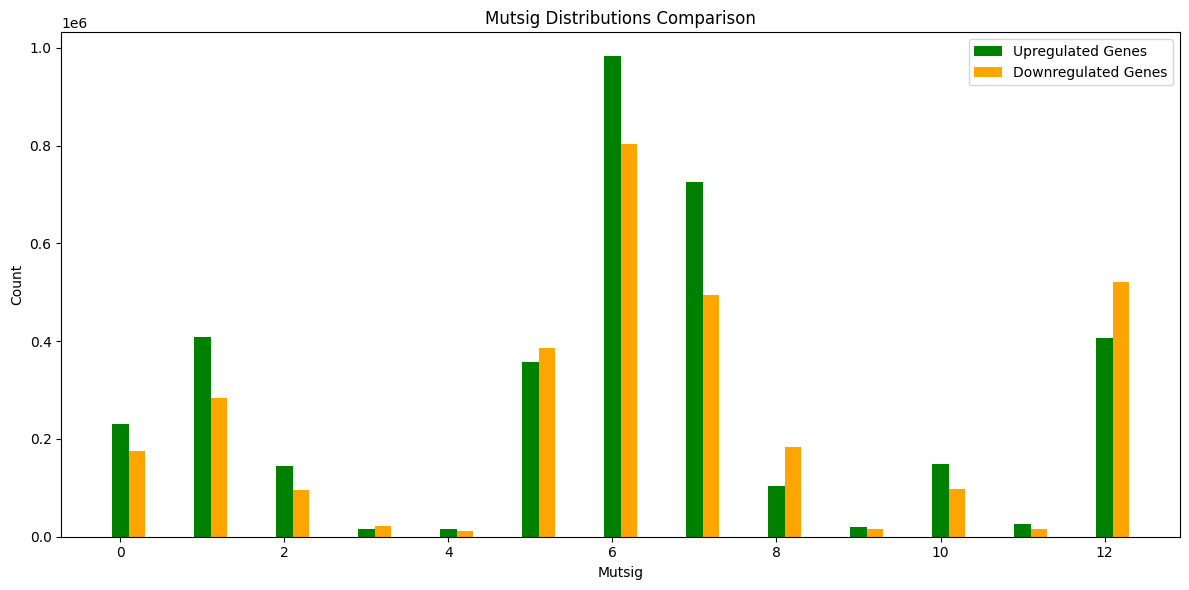

In [ ]:

plt.figure(figsize=(12, 6))

# Set width of bars and positions
bar_width = 0.2
r1 = np.arange(len(up_onc_dist))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, all_upregulated_dist.values, width=bar_width, label='Upregulated Genes', color='green')
plt.bar(r2, all_downregulated_dist.values, width=bar_width, label='Downregulated Genes', color='orange')

# Add labels and title
plt.xlabel('Mutsig')
plt.ylabel('Count')
plt.title('Mutsig Distributions Comparison')

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [29]:
sign_upreg_list = df[upreg & sign]['gene_id'].tolist()
sign_downreg_list = df[downreg & sign]['gene_id'].tolist()

upreg_families = real[real.gene_id.isin(sign_upreg_list)].mirna_family.value_counts().compute()
downreg_families = real[real.gene_id.isin(sign_downreg_list)].mirna_family.value_counts().compute()

# Calculate the distributions for upregulated and downregulated families
upreg_families = upreg_families.nlargest(10)
downreg_families = downreg_families.nlargest(10)
